<a href="https://colab.research.google.com/github/katty-anay/Fluid_mechanics_/blob/main/Report-Elasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Elasticity equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Elasticity equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [10]:
# This program has been written with a template from
# DD2365 Advanced Computation in Fluid Mechanics,
# KTH Royal Institute of Technology, Stockholm, Sweden.

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This report has been written by Katty Raboanarijaona (20021105-T545)

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [11]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Elasticity equations take the form

$-\nabla \cdot \sigma = f$

together with suitable boundary conditions.

To derive the weak form of the equations, multiply the equation by $v\in V$, and then integrate over the domain $\Omega$ and use Green's formula
$
(-\nabla \cdot \sigma ,v) = (\nabla \sigma , \nabla v)
- <\sigma \cdot n, v>_{\Gamma}
$

To model

We seek a finite element approximation $u\in V$ such that

$(\nabla \sigma,\nabla v) - <\sigma \cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $v \in V$.



# **Method**

**Define domain and mesh**

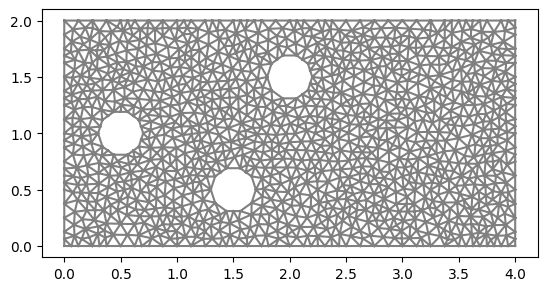

In [12]:
# Define rectangular domain
L = 4.0
H = 2.0

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(1.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [13]:
# Generate finite element space
VE = VectorElement("CG", mesh.ufl_cell(), 1)

V = FunctionSpace(mesh, VE)

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

d = Function(V)

**Define boundary conditions**

In [14]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

bcu_left0 = DirichletBC(V.sub(0), 0.0, dbc_left)
bcu_left1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_right0 = DirichletBC(V.sub(0), 0.0, dbc_right)
bcu_right1 = DirichletBC(V.sub(1), 0.0, dbc_right)
bcu_upper0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upper1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_lower0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_lower1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.5, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

bcu = [bcu_left0, bcu_left1, bcu_right0, bcu_right1, bcu_upper0, bcu_upper1, bcu_lower0, bcu_lower1, bcu_obj0, bcu_obj1]

# **Results**

**Define and solve variational problem**

In [15]:
f = Expression(("0.0","0.0"), element = V.ufl_element())

dim = u.geometric_dimension()
E = 1.0e10
nu = 0.0
mu = E*0.5/(1+nu)
lambda_ = nu*E/((1.0+nu)*(1.0-2.0*nu))

def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)

def sigma(u):
    #return 2.0*mu*epsilon(u)
    return lambda_*div(u)*Identity(dim) + 2.0*mu*epsilon(u)

# Define variational problem on residual form: r(u,v) = 0
residual = ( inner(sigma(u), epsilon(v))*dx - inner(f, v)*dx )

au = lhs(residual)
Lu = rhs(residual)

A = assemble(au)
b = assemble(Lu)

[bc.apply(A, b) for bc in bcu]
[bc.apply(d.vector()) for bc in bcu]

solve(A, d.vector(), b, "bicgstab", "default")

17

**Visualize solution and export files**

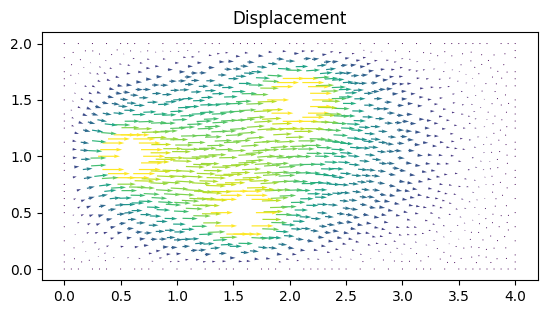

In [16]:
u1 = project(d, V)

# Plot solution
plt.figure()
plot(u1, title="Displacement")

plt.show()

**Computation of stress**

In [17]:
W = TensorFunctionSpace(mesh, "CG", 1)
stress = project(sigma(d), W)
stress_array = stress.vector().get_local()

print(f"Max stress: {np.max(abs(stress_array)):.2e}")
print(f"Mean stress: {np.mean(abs(stress_array)):.2e}")

Max stress: 1.94e+10
Mean stress: 1.50e+09


**Update mesh**

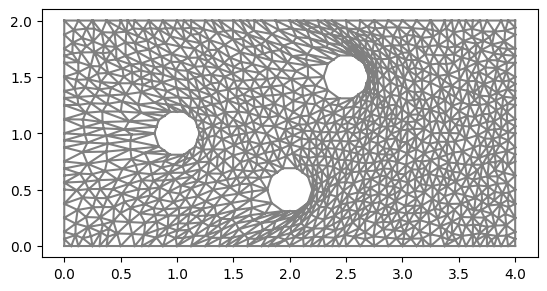

In [18]:
ALE.move(mesh, d)
plt.figure()
plot(mesh)
plt.show()

## Mesh deformation with the cylinders movement

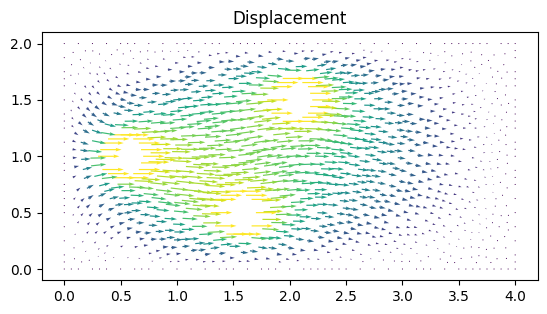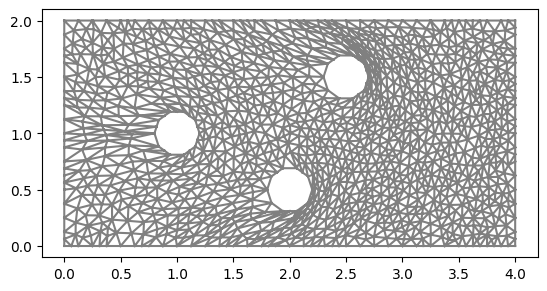

# Changing parameters

**For E=1e10 and nu=0.3 :**

Max stress: 2.34e+10

Mean stress: 1.66e+09

Displacement and mesh deformation above.

**For E=3e6 and nu=0.3 :**

Max stress: 7.03e+06

Mean stress: 4.99e+05

Displacement and mesh deformation unchanged.

**For E=1e10 and nu=0.49 :**

Max stress: 1.61e+11

Mean stress: 1.09e+10

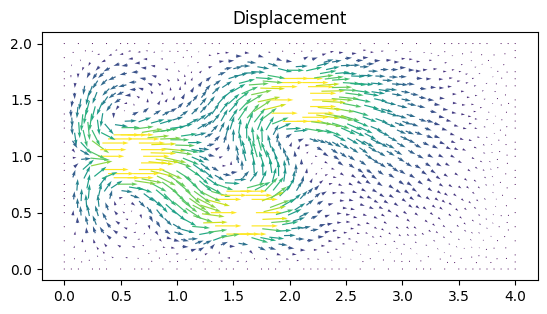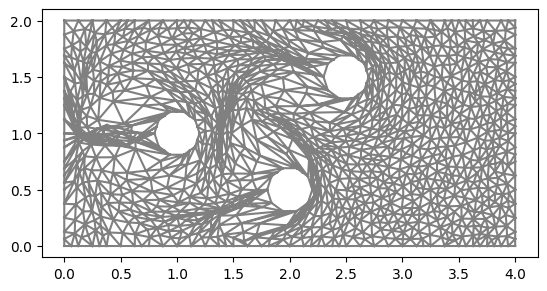

**For E=1e10 and nu=-0.3 :**

Max stress: 2.33e+10

Mean stress: 2.04e+09

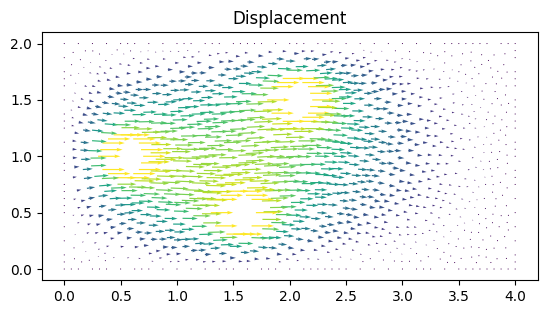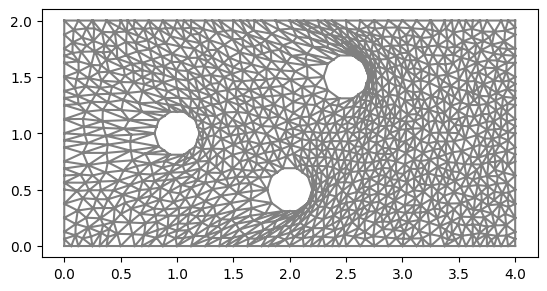

# Changing the cylinders movement

**The original movement (1) :**

bcu_obj0 = DirichletBC(V.sub(0), 0.5, dbc_objects)

bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

Plots above.


**The alternative movement (2) :**

bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)

bcu_obj1 = DirichletBC(V.sub(1), 0.2, dbc_objects)

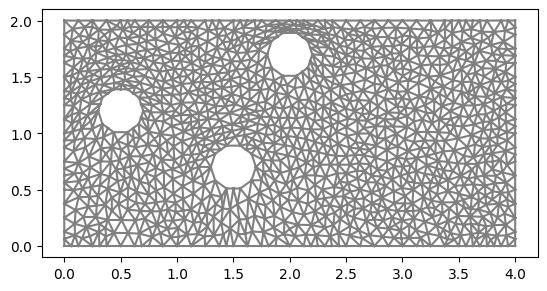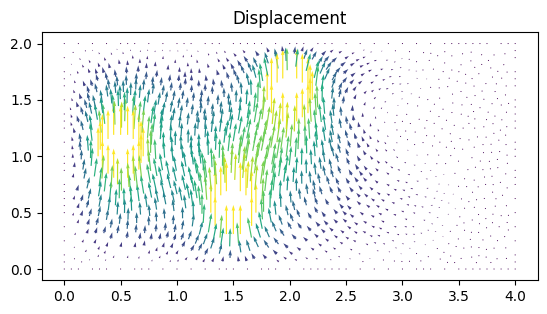

**The alternative movement (3) :**

bcu_obj0 = DirichletBC(V.sub(0), 0.8, dbc_objects)

bcu_obj1 = DirichletBC(V.sub(1), 0.2, dbc_objects)

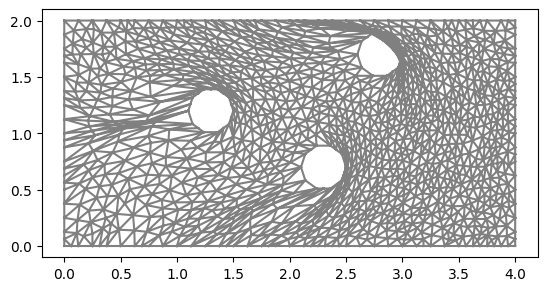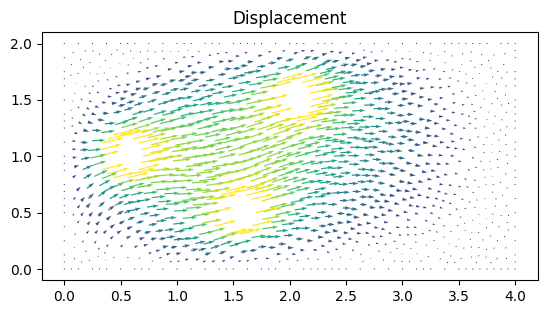

**The alternative movement (4) :**

bcu_obj0 = DirichletBC(V.sub(0), -0.5, dbc_objects)

bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

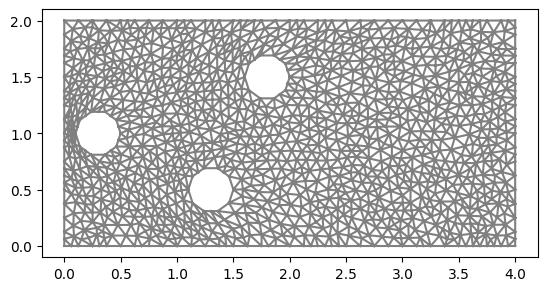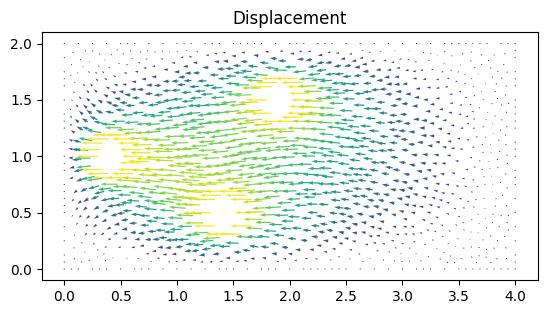

# **Discussion**

A Elasticity equation was solved with a finite element method.

## Changing parameters

We modified Young's modulus and Poisson's ratio to observe if it leads to any modification in the mesh deformation.

We observe that changing the Young's modulus does not change the overall shape of the mesh deformation. By definition, the material is more rigid or stiff thus the stress magnitude drops when the modulus is set to E=1.0e6 instead of E=1.0e10.

However when changing Poisson's ratio we observe severe modification in the mesh deformation. For instance, when ν ≈ 0.5 (ν=0.49), the material is theorically incompressible and we observe that the mesh becomes really coarse in some regions. It is due to the fact the volume cannot change (at least it is conserved locally).
We also note that taking a negative value for ν does not change drastically the result (between ν=0.3 and ν=-0.3).

The mesh deformation and the displacement are correlated and we observe that for the incompressible case the displacement is no longer only longitunal, it contains some rotations. And we may notice that they are very close to the regions with coarser mesh.

## Changing the cylinders movement

Initially, the displacement is along the horizontal axis and oriented to the right-hand side boundary and we observe that the mesh is getting thinner near the cylinders on their right-hand side.

For displacement along the vertical axis and oriented to the top boundary (2), we observe that the mesh is getting thinner near the cylinder on their top side.

Thus the mesh deformation follows the orientation of the displacement as we can also see in (4) where the displacement is oriented to the left boundary.


If horizontal and vertical movement are combined (3), we observe the combination of the two observations above. But in this case, the horizontal displacement is bigger than before, indeed the boundary condition (along x) on the cylinder is set to 0.8 in (3) wheras it was 0.5 in (1). This bigger displacement leads to bigger deformations in the mesh and we observe that the mesh is thinner in the top right-hand corner than in the bottom left-hand corner. The mesh deformation captures the movement dominant directions to keep a high level of accuracy.


